In [53]:
%load_ext autoreload
%autoreload 2 

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import neuralGrU
from GrU import (evaluate, GrU)
from helpers import (total_loss, squash, getPriceVectors, barrier_loss, source)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Grid vs PV (no constraint)

In [55]:
# Init model
B_init = 2
eta = 1
scaler = 1
ep = np.ones(24)

model = neuralGrU(B=B_init, n_agents=1, ep=ep, gamma=[0], eta_c=eta, eta_d=eta, alpha=1e3).to(device)

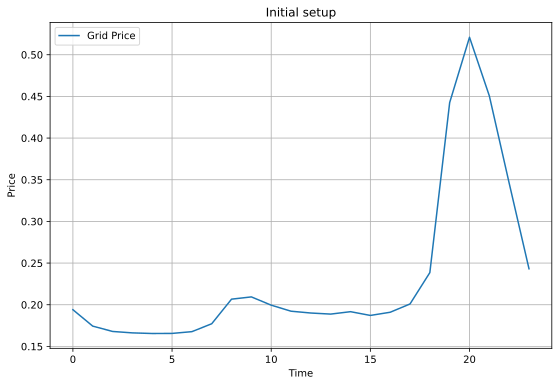

In [134]:
# Price vectors from Auction Data
prices = getPriceVectors(300) * scaler

# Scale grid prices with non-linear min-max scaler
prices[source.grid] = squash(prices[source.grid], scale=2)

# Init pv price close to 0
prices[source.pv] = 1e-3

# Init Charge, discharge & storage to inf
prices[source.charge:] = 1e6

# Total demand vector
demandTotal = np.array( [ 6.977, 4.481, 5.309, 3.792, 3.726, 3.611, 4.774, 6.38, 8.807, 7.441, 6.983, 6.836, 7.285, 7.132, 7.743, 7.396, 9.289, 8.745, 9.847, 12.738, 15.76, 16.945, 15.414, 11.289 ] )

plt.figure(figsize=(9,6))
plt.title('Initial setup')
# plt.plot(prices[source.pv], label='PV Price')
plt.plot(prices[source.grid], label='Grid Price')
# plt.plot(demandTotal / 10, label='Total Demand (x10)')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( "Results/results1.pdf", bbox_inches='tight' )

plt.show()

In [57]:
# Total demand tensor
# d_t = torch.ones((1, 24), requires_grad=False, device=device) 
d_t = torch.tensor(demandTotal, requires_grad=False, device=device)

# # Cap tensor
# C_p = torch.ones((1, 24), requires_grad=False) * 4

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [58]:
# Hyperparameter(s)
learning_rate = 0.01
epochs = 300

history = []
best_loss = 0
model.B = B_init

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star.squeeze())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 300/300 [00:04<00:00, 74.50it/s]


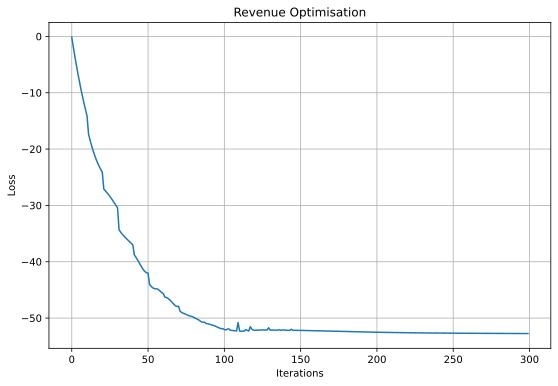

In [59]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Optimisation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( "Results/results2.pdf", bbox_inches='tight' )

plt.show()

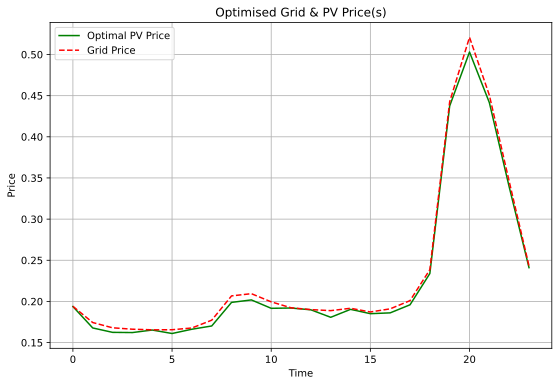

In [60]:
prices_pv_optimal = pi_optimal[0].numpy()
prices_pv_current = pi_p.detach().numpy()

plt.figure(figsize=(9,6))
plt.title('Optimised Grid & PV Price(s)')
plt.plot(prices_pv_optimal, label='Optimal PV Price', color='g')
# plt.plot(prices_pv_current, label='Current PV Price', color='pink')
plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='r')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( "Results/results3.pdf", bbox_inches='tight' )

plt.show()

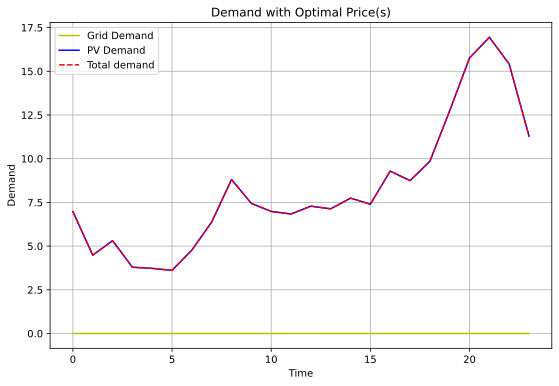

In [61]:
pi_p, pi_s, pi_c, pi_d = pi_optimal
d_star_optimal = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).squeeze().detach().numpy()
d_total = d_t.detach().numpy().T


plt.figure(figsize=(9,6))
plt.title('Demand with Optimal Price(s)')
plt.plot(d_star_optimal[source.grid], label='Grid Demand', color='y')
plt.plot(d_star_optimal[source.pv], label='PV Demand', color='b')
plt.plot(d_total, label='Total demand', linestyle='dashed', color='r')
plt.ylabel('Demand')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( "Results/results4.pdf", bbox_inches='tight' )

plt.show()

## Grid vs Battery (no constraint)

In [62]:
# Init model
B_init = 2
eta = 1
scaler = 1
ep = np.ones(24)

model = neuralGrU(B=B_init, n_agents=1, ep=ep, gamma=[0], eta_c=eta, eta_d=eta, alpha=1e3).to(device)

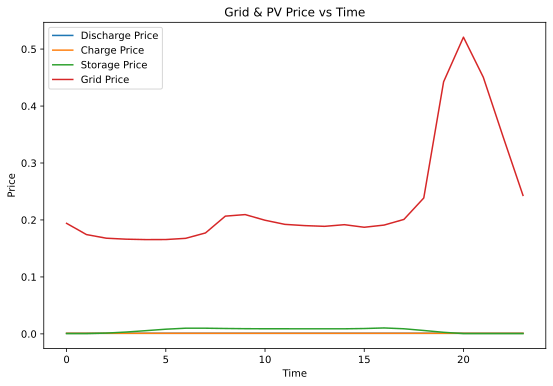

In [63]:
# Price vectors from Auction Data
prices = getPriceVectors(300) * scaler

# Scale grid prices with non-linear min-max scaler
prices[source.grid] = squash(prices[source.grid], scale=2)

# Init pv price to alpha (inf)
prices[source.pv] = 1e6

# Init Charge, discharge & storage close to 0
prices[source.charge:] = 1e-3

# Total demand vector
demandTotal = np.array( [ 6.977, 4.481, 5.309, 3.792, 3.726, 3.611, 4.774, 6.38, 8.807, 7.441, 6.983, 6.836, 7.285, 7.132, 7.743, 7.396, 9.289, 8.745, 9.847, 12.738, 15.76, 16.945, 15.414, 11.289 ] )

# plt.figure(figsize=(9,6))
# plt.title('Grid & PV Price vs Time')
# plt.plot(prices[source.discharge], label='Discharge Price')
# plt.plot(prices[source.charge], label='Charge Price')
# plt.plot(prices[source.storage], label='Storage Price')
# plt.plot(prices[source.grid], label='Grid Price')
# plt.ylabel('Price')
# plt.xlabel('Time')
# plt.legend()
# plt.show()

In [64]:
# Total demand tensor
# d_t = torch.ones((1, 24), requires_grad=False, device=device) 
d_t = torch.tensor(demandTotal, requires_grad=False, device=device)

# # Cap tensor
# C_p = torch.ones((1, 24), requires_grad=False) * 4

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [65]:
# Hyperparameter(s)
learning_rate = 0.005
epochs = 500

history = []
best_loss = 0
model.B = B_init

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star.squeeze())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if t > 25 and loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:06<00:00, 74.20it/s]


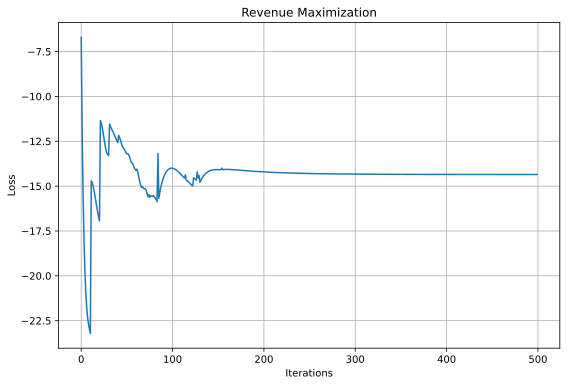

In [66]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( "Results/results5.pdf", bbox_inches='tight' )

plt.show()

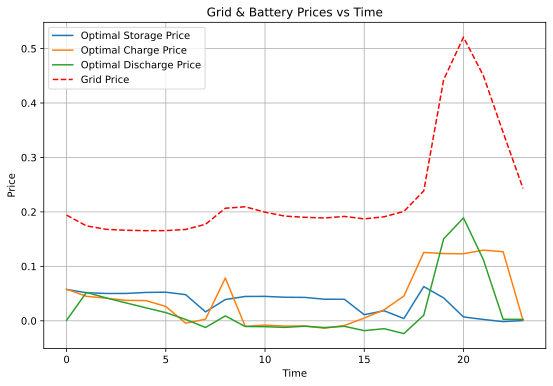

In [67]:
prices_battery_optimal = [pi.numpy() for pi in pi_optimal[1:]]

plt.figure(figsize=(9,6))
plt.title('Grid & Battery Prices vs Time')
plt.plot(prices_battery_optimal[0], label='Optimal Storage Price')
plt.plot(prices_battery_optimal[1], label='Optimal Charge Price')
plt.plot(prices_battery_optimal[2], label='Optimal Discharge Price')
plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='red')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( f"Results/results6.pdf", bbox_inches='tight' )

plt.show()

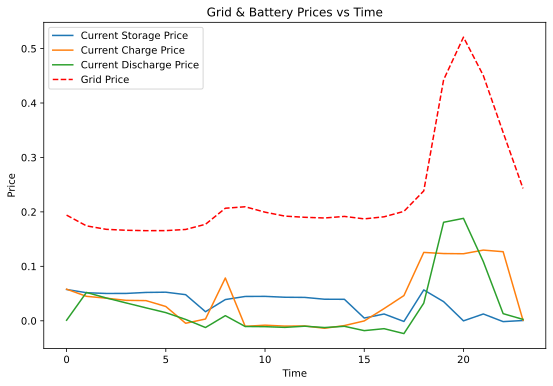

In [68]:
# prices_battery_current = [pi.detach().numpy() for pi in (pi_s, pi_c, pi_d)]

# plt.figure(figsize=(9,6))
# plt.title('Grid & Battery Prices vs Time')
# plt.plot(prices_battery_current[0], label='Current Storage Price')
# plt.plot(prices_battery_current[1], label='Current Charge Price')
# plt.plot(prices_battery_current[2], label='Current Discharge Price')
# plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='red')
# plt.ylabel('Price')
# plt.xlabel('Time')
# plt.legend()
# plt.show()

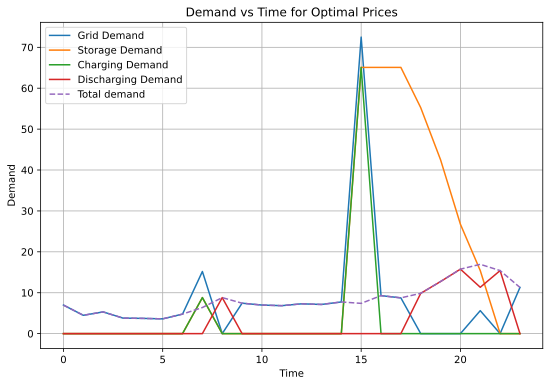

In [69]:
pi_p_opt, pi_s_opt, pi_c_opt, pi_d_opt = pi_optimal
d_star_optimal = model(pi_g, pi_p_opt, pi_s_opt, pi_c_opt, pi_d_opt, d_t).squeeze().detach().numpy()
d_total = d_t.detach().numpy().T


plt.figure(figsize=(9,6))
plt.title('Demand vs Time for Optimal Prices')
plt.plot(d_star_optimal[source.grid], label='Grid Demand')
# plt.plot(d_star_optimal[source.pv], label='PV Demand')
plt.plot(d_star_optimal[source.storage], label='Storage Demand')
plt.plot(d_star_optimal[source.charge], label='Charging Demand')
plt.plot(d_star_optimal[source.discharge], label='Discharging Demand')
plt.plot(d_total, label='Total demand', linestyle='dashed')
plt.ylabel('Demand')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( f"Results/results7.pdf", bbox_inches='tight' )

plt.show()

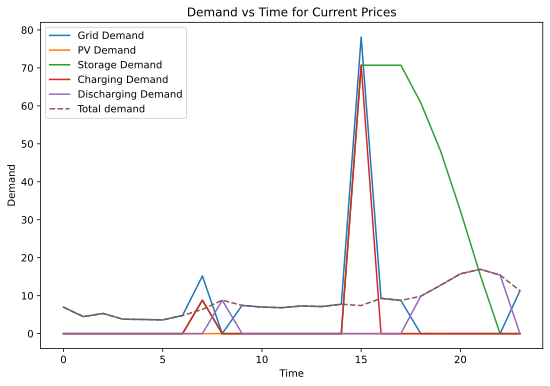

In [70]:
# d_star_optimal = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).squeeze().detach().numpy()
# d_total = d_t.detach().numpy().T


# plt.figure(figsize=(9,6))
# plt.title('Demand vs Time for Current Prices')
# plt.plot(d_star_optimal[source.grid], label='Grid Demand')
# plt.plot(d_star_optimal[source.pv], label='PV Demand')
# plt.plot(d_star_optimal[source.storage], label='Storage Demand')
# plt.plot(d_star_optimal[source.charge], label='Charging Demand')
# plt.plot(d_star_optimal[source.discharge], label='Discharging Demand')
# plt.plot(d_total, label='Total demand', linestyle='dashed')
# plt.ylabel('Demand')
# plt.xlabel('Time')
# plt.legend()
# plt.show()

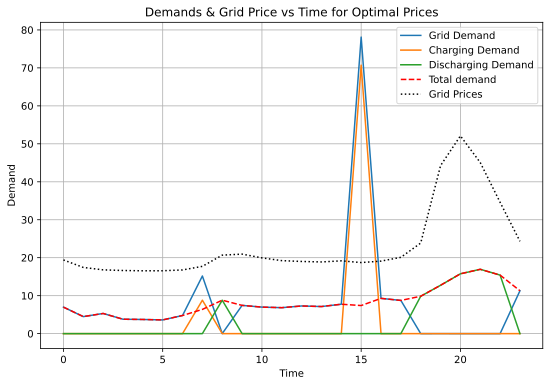

In [77]:
d_total = d_t.detach().numpy().T

plt.figure(figsize=(9,6))
plt.title('Demands & Grid Price vs Time for Optimal Prices')
plt.plot(d_star_optimal[source.grid], label='Grid Demand')
# plt.plot(d_star_optimal[source.pv], label='PV Demand')
# plt.plot(d_star_optimal[source.storage], label='Storage Demand')
plt.plot(d_star_optimal[source.charge], label='Charging Demand')
plt.plot(d_star_optimal[source.discharge], label='Discharging Demand')
plt.plot(d_total, label='Total demand', linestyle='dashed', color='red')
plt.plot(prices[source.grid] * 100, label='Grid Prices', linestyle='dotted', color='black')
plt.ylabel('Demand')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( f"Results/results8.pdf", bbox_inches='tight' )

plt.show()

## Grid vs All with Cap (single user & no EI)

In [72]:
# Init model
B_init = 1
eta = 1
scaler = 1
ep = np.ones(24)

model = neuralGrU(B=B_init, n_agents=1, ep=ep, gamma=[0], eta_c=eta, eta_d=eta, alpha=1e3).to(device)

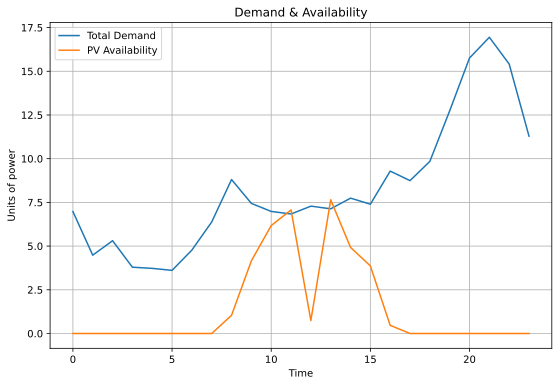

In [73]:
# Price vectors from Auction Data
prices = getPriceVectors(300) * scaler

# Scale grid prices with non-linear min-max scaler
prices[source.grid] = squash(prices[source.grid], scale=2)

# Init pv, discharge, charge & storage prices close to 0
prices[source.pv:] = 1e-3

# Total demand vector
demandTotal = np.array( [ 6.977, 4.481, 5.309, 3.792, 3.726, 3.611, 4.774, 6.38, 8.807, 7.441, 6.983, 6.836, 7.285, 7.132, 7.743, 7.396, 9.289, 8.745, 9.847, 12.738, 15.76, 16.945, 15.414, 11.289 ] )

# PV constraint
pvCap = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1.04138, 4.1586, 6.17582, 7.06937, 0.741387, 7.6486, 4.92515, 3.86719, 0.466317, 0, 0, 0, 0, 0, 0, 0])

plt.figure(figsize=(9,6))
plt.title('Demand & Availability')
# plt.plot(prices[source.grid], label='Grid Price')
plt.plot(demandTotal, label='Total Demand')
plt.plot(pvCap, label='PV Availability')
plt.ylabel('Units of power')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( f"Results/results9.pdf", bbox_inches='tight' )

plt.show()

In [74]:
# Total demand tensor
d_t = torch.tensor(demandTotal, requires_grad=False, device=device).unsqueeze(dim=0)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Cap tensor
C_p = torch.tensor(pvCap, requires_grad=False, device=device).unsqueeze(dim=0)
# C_d = torch.ones((1, 24), requires_grad=False) * 4

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [75]:
# Hyperparameter(s)
learning_rate = 0.005
epochs = 300

history = []
best_loss = 0
model.B = B_init

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star.squeeze())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 300/300 [00:04<00:00, 72.45it/s]


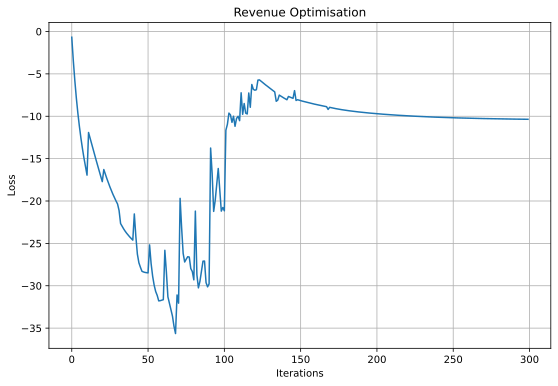

In [86]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Optimisation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( f"Results/results10.pdf", bbox_inches='tight' )

plt.show()

In [78]:
best_loss, loss

(-35.63722807135208, -10.357220803400526)

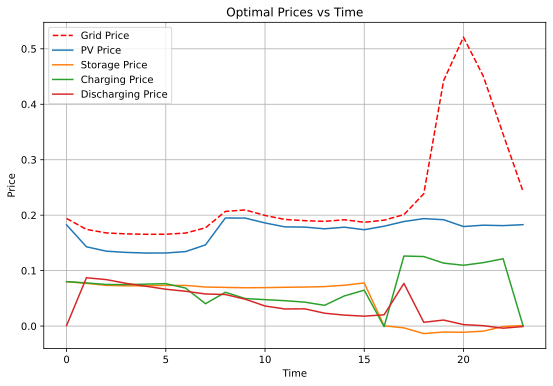

In [79]:
# prices_pv_optimal = pi_optimal[0].numpy()
prices_optimal = [pi.detach().numpy() for pi in pi_optimal]

plt.figure(figsize=(9,6))
plt.title('Optimal Prices vs Time')

plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='red')
plt.plot(prices_optimal[0], label='PV Price')
plt.plot(prices_optimal[1], label='Storage Price')
plt.plot(prices_optimal[2], label='Charging Price')
plt.plot(prices_optimal[3], label='Discharging Price')

plt.ylabel('Price')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( f"Results/results11.pdf", bbox_inches='tight' )

plt.show()

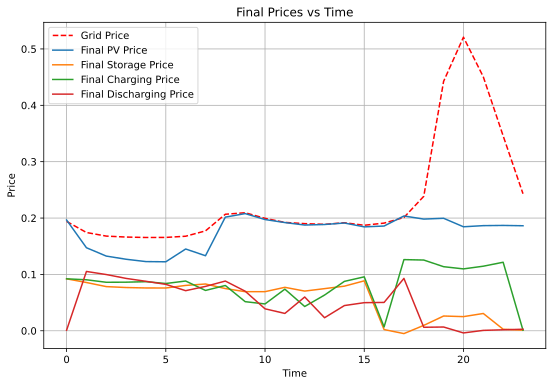

In [80]:
# prices_pv_optimal = pi_optimal[0].numpy()
prices_final = [pi.detach().numpy() for pi in (pi_p, pi_s, pi_c, pi_d)]

plt.figure(figsize=(9,6))
plt.title('Final Prices vs Time')

plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='red')
plt.plot(prices_final[0], label='Final PV Price')
plt.plot(prices_final[1], label='Final Storage Price')
plt.plot(prices_final[2], label='Final Charging Price')
plt.plot(prices_final[3], label='Final Discharging Price')

plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

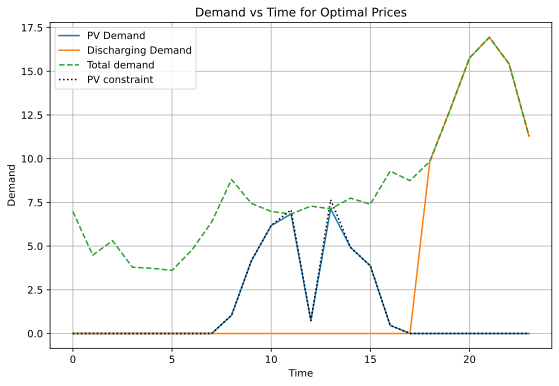

In [84]:
pi_p_opt, pi_s_opt, pi_c_opt, pi_d_opt = pi_optimal
d_star_optimal = model(pi_g, pi_p_opt, pi_s_opt, pi_c_opt, pi_d_opt, d_t, C_p).squeeze().detach().numpy()
d_total = d_t.detach().numpy().T


plt.figure(figsize=(9,6))
plt.title('Demand vs Time for Optimal Prices')
# plt.plot(d_star_optimal[source.grid], label='Grid Demand')
plt.plot(d_star_optimal[source.pv], label='PV Demand')
# plt.plot(d_star_optimal[source.storage], label='Storage Demand')
# plt.plot(d_star_optimal[source.charge], label='Charging Demand')
plt.plot(d_star_optimal[source.discharge], label='Discharging Demand')
plt.plot(d_total, label='Total demand', linestyle='dashed')
plt.plot(pvCap, label='PV constraint', linestyle='dotted', color='black')
plt.ylabel('Demand')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( f"Results/results12.pdf", bbox_inches='tight' )

plt.show()

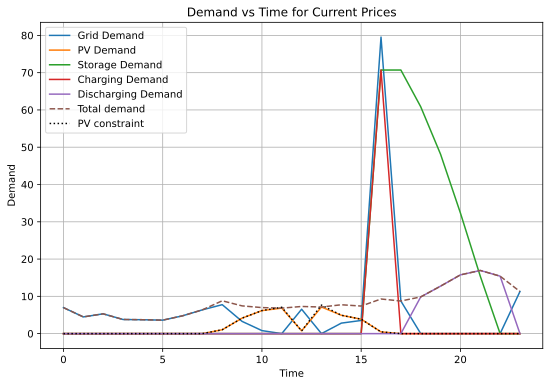

In [85]:
# d_star_final = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p).squeeze().detach().numpy()
d_total = d_t.detach().numpy().T
d_star_final = d_star.squeeze().detach().numpy()


plt.figure(figsize=(9,6))
plt.title('Demand vs Time for Current Prices')
plt.plot(d_star_final[source.grid], label='Grid Demand')
plt.plot(d_star_final[source.pv], label='PV Demand')
plt.plot(d_star_final[source.storage], label='Storage Demand')
plt.plot(d_star_final[source.charge], label='Charging Demand')
plt.plot(d_star_final[source.discharge], label='Discharging Demand')
plt.plot(d_total, label='Total demand', linestyle='dashed')
plt.plot(pvCap, label='PV constraint', linestyle='dotted', color='black')
plt.ylabel('Demand')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( f"Results/results13.pdf", bbox_inches='tight' )

plt.show()

## Grid vs PV (no constraint)

In [93]:
# Init model
B_init = 2
eta = 1
scaler = 1
ep = np.ones(24)

model = neuralGrU(B=B_init, n_agents=1, ep=ep, gamma=[0], eta_c=eta, eta_d=eta, alpha=1e3).to(device)

In [94]:
# Price vectors from Auction Data
prices = getPriceVectors(300) * scaler

# Scale grid prices with non-linear min-max scaler
prices[source.grid] = squash(prices[source.grid], scale=2)

# Init pv price close to 0
prices[source.pv] = 1e-3

# Init Charge, discharge & storage to inf
prices[source.charge:] = 1e6

# Total demand vector
demandTotal = np.array( [ 6.977, 4.481, 5.309, 3.792, 3.726, 3.611, 4.774, 6.38, 8.807, 7.441, 6.983, 6.836, 7.285, 7.132, 7.743, 7.396, 9.289, 8.745, 9.847, 12.738, 15.76, 16.945, 15.414, 11.289 ] )

# PV constraint
pvCap = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1.04138, 4.1586, 6.17582, 7.06937, 0.741387, 7.6486, 4.92515, 3.86719, 0.466317, 0, 0, 0, 0, 0, 0, 0])


In [120]:
# Total demand tensor
# d_t = torch.ones((1, 24), requires_grad=False, device=device) 
d_t = torch.tensor(demandTotal, requires_grad=False, device=device)

# Cap tensor
C_p = torch.tensor(pvCap, requires_grad=False, device=device).unsqueeze(dim=0)

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [121]:
# Hyperparameter(s)
learning_rate = 0.006
epochs = 300

history = []
best_loss = 0
model.B = B_init

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star.squeeze())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 300/300 [00:01<00:00, 157.31it/s]


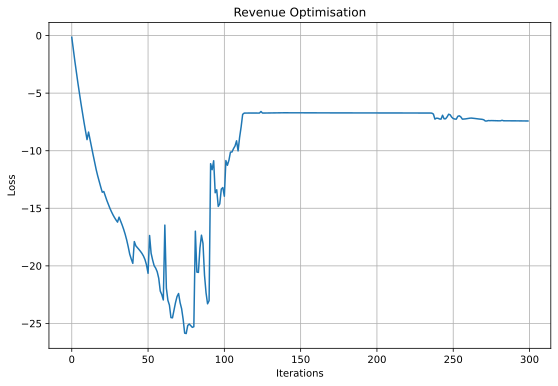

In [131]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Optimisation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( "Results/results14.pdf", bbox_inches='tight' )

plt.show()

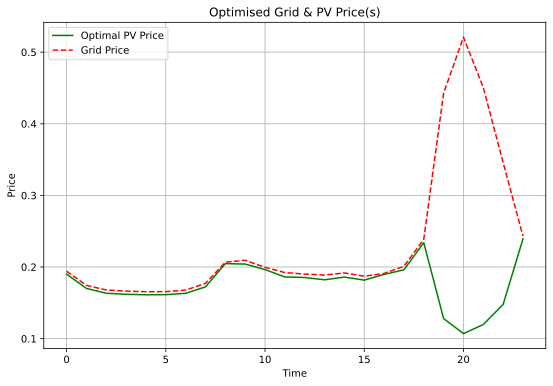

In [132]:
prices_pv_optimal = pi_optimal[0].numpy()
# prices_pv_current = pi_p.detach().numpy()

plt.figure(figsize=(9,6))
plt.title('Optimised Grid & PV Price(s)')
plt.plot(prices_pv_optimal, label='Optimal PV Price', color='g')
# plt.plot(prices_pv_current, label='Current PV Price', color='pink')
plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='r')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( "Results/results15.pdf", bbox_inches='tight' )

plt.show()

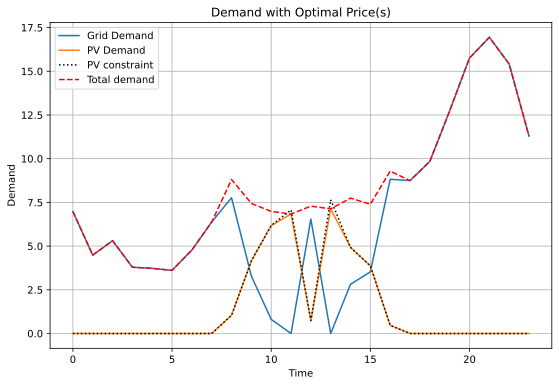

In [133]:
pi_p, pi_s, pi_c, pi_d = pi_optimal
d_star_optimal = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p).squeeze().detach().numpy()
d_total = d_t.detach().numpy().T


plt.figure(figsize=(9,6))
plt.title('Demand with Optimal Price(s)')
plt.plot(d_star_optimal[source.grid], label='Grid Demand')
plt.plot(d_star_optimal[source.pv], label='PV Demand')
plt.plot(pvCap, label='PV constraint', linestyle='dotted', color='black')
plt.plot(d_total, label='Total demand', linestyle='dashed', color='r')
plt.ylabel('Demand')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.rcParams[ 'pdf.fonttype' ] = 42
plt.rcParams[ 'ps.fonttype' ] = 42
plt.savefig( "Results/results16.pdf", bbox_inches='tight' )

plt.show()